# DoorDash ETA Prediction

#### Objective in Business Terms
The Estimated Time of Arrival (ETA) is a key metric for DoorDash, influencing customer satisfaction, operational efficiency, and overall market competitiveness. When customers place an order, an accurate ETA not only sets realistic expectations but also enhances their trust in the service. For DoorDash, this translates into improved retention, better allocation of resources, and reduced churn rates. Similar problems in logistics and food delivery competitors (Uber Eats, Grubhub...) are also addressing same operationl issues.

Currently, DoorDash employs predictive models for various delivery stages, such as order placement duration and driving time. They deploy such model to provide real-time delivery estimates to customers during the ordering process. It can also aid in optimizing dasher dispatch and route planning for better marketplace management.

This solution aims to predict the total delivery duration (in seconds) for DoorDash orders, from the moment a customer submits an order to the time the delivery is completed. The problem is framed as a supervised learning regression task, given the continuous nature of the target variable: delivery duration in seconds. Performance will be evaluated using regression metrics such as MSE, MAE, R-square scores

#### Data Acquisition
The dataset used for this task is provided by DoorDash, ensuring its relevance and accuracy for the problem. It is available on Kaggle:

https://www.kaggle.com/datasets/dharun4772/doordash-eta-prediction

#### Data dictionary
The dataset contains historical delivery records from early 2015 in select cities. Each row corresponds to a unique delivery, with added noise to obfuscate sensitive business details. All money (dollar) values given in the data are in "cents" and all time duration values given are in "seconds"

**Time features**
- market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
- created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
- actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

**Store features**
- store_id: an id representing the restaurant the order was submitted for
- store_primary_category: cuisine category of the restaurant, e.g., italian, asian
- order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

**Order features**
- total_items: total number of items in the order
- subtotal: total value of the order submitted (in cents)
- num_distinct_items: number of distinct items included in the order
- min_item_price: price of the item with the least cost in the order (in cents)
- max_item_price: price of the item with the highest cost in the order (in cents)

#### Environment and package setup

This project requires Python 3.12.5 or above:

In [7]:
import sys

assert sys.version_info >= (3, 12)

AssertionError: 

It also requires Scikit-Learn ≥ 1.5.1:

In [9]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.2.


In [10]:
from packaging import version

assert version.parse(sklearn.__version__) >= version.parse("1.5.1")

#### Read Data

In [11]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = os.getcwd()
os.chdir(path)

# Display all columns in the console
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv("0119_Shuxi Chen_HW1_DoorDash ETA Prediction.csv")
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


## Take a Quick Look at the Data Structure

In [12]:
df.describe(include = "all")

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428,197421,197428.000000,192668,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
unique,NaN,180985,178110,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2015-02-11 19:50:43,2015-02-11 20:40:45,NaN,american,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,6,5,NaN,19399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.978706,NaN,NaN,3530.510272,NaN,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,NaN,NaN,2053.496711,NaN,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,NaN,NaN,1.000000,NaN,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,NaN,NaN,1686.000000,NaN,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,NaN,NaN,3592.000000,NaN,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,NaN,NaN,5299.000000,NaN,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000


The minimum of min_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders should >= 0

In [13]:
print(len(df[df["min_item_price"] < 0]))
print(len(df[df["total_onshift_dashers"] < 0]))
print(len(df[df["total_busy_dashers"] < 0]))
print(len(df[df["total_outstanding_orders"] < 0]))

13
21
21
44


In [14]:
print(df.shape)
df.info()

(197428, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                     

Since the goal is to predict the total delivery duration, it's fundimental to create the duration from created_at & actual_delivery_time.

In [15]:
time_cols = ["created_at", "actual_delivery_time"]

# convert object to time
for col in time_cols:
    df[col] = pd.to_datetime(df[col])

df["duration"] = (df["actual_delivery_time"] - df["created_at"]).dt.total_seconds()
df["order_hour"] = df["created_at"].dt.hour
df["order_day"] = df["created_at"].dt.dayofweek
df["order_month"] = df["created_at"].dt.month

Data distribution

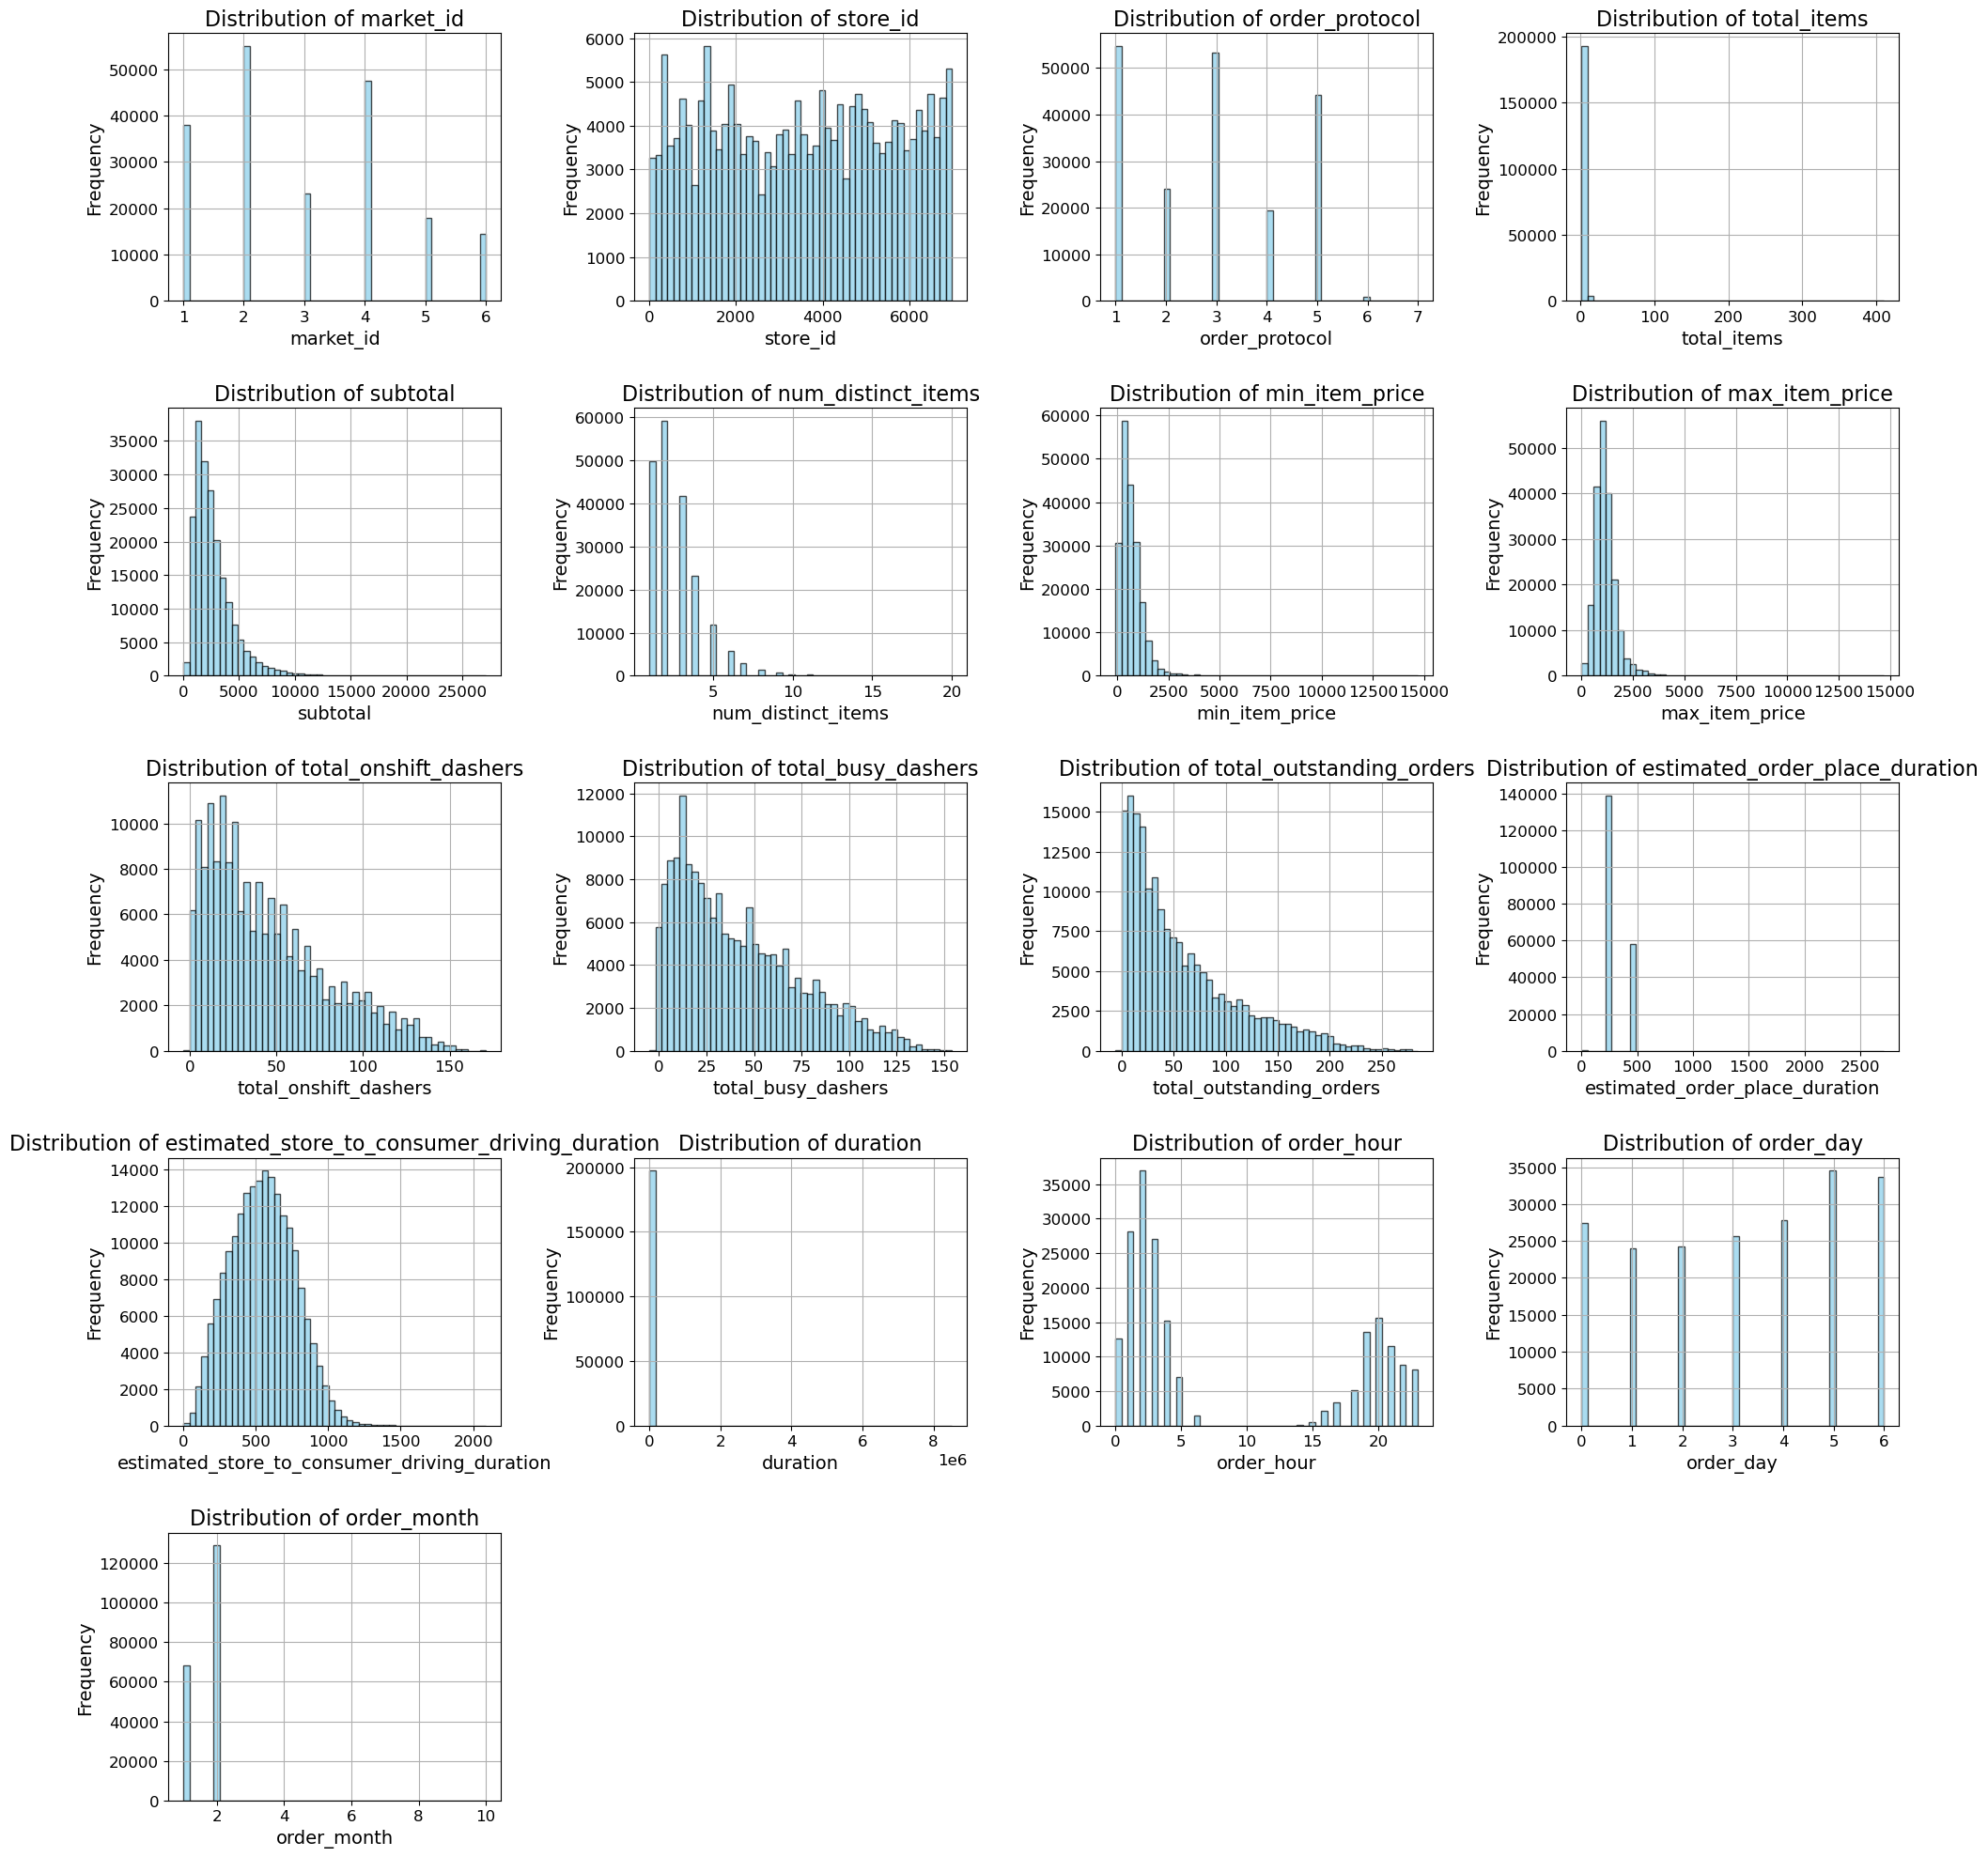

In [16]:
import math

# font and label sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=16)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

numeric_columns = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

# grid size
num_cols = len(numeric_columns)
num_rows = math.ceil(num_cols / 4)  # 4 columns per row

# figure size and create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, num_rows * 4))
axes = axes.flatten()  # flatten the axes for easy iteration

for i, col in enumerate(numeric_columns):
    df[col].hist(bins=50, ax=axes[i], alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [17]:
print(len(df["store_primary_category"].value_counts()))
df["store_primary_category"].value_counts()

74


store_primary_category
american             19399
pizza                17321
mexican              17099
burger               10958
sandwich             10060
chinese               9421
japanese              9196
dessert               8773
fast                  7372
indian                7314
thai                  7225
italian               7179
vietnamese            6095
mediterranean         5512
breakfast             5425
other                 3988
salad                 3745
greek                 3326
seafood               2730
barbecue              2722
asian                 2449
cafe                  2229
sushi                 2187
alcohol               1850
korean                1813
smoothie              1659
catering              1633
middle-eastern        1501
hawaiian              1499
dim-sum               1112
steak                 1092
vegetarian             845
burmese                821
pasta                  633
persian                607
french                 575
latin

Some variables have extreme values that seems unrealistic and should be removed:
- total_items: it has values over 400
- estimated_order_place_duration: it has values greater than 2500 seconds (~42 minutes) for order placement are outliers.
- duration: it has values over 8,000,000 seconds (~99 days)
- order_month: the dataset is supposed to contain data only from the beginning of the year, but months like October (order_month = 10) appear.

Other variables have understandable outliers due to their natural distributions.

#### Correct time data
Since the data split will be based on date, start by inspecting the problematic dates and fixing any issues

In [18]:
incorrect_rows = df["order_month"] > 2
print(df[incorrect_rows])

# If the corrected created_at is in the wrong month and year and cannot be accurately fixed, 
# the best course of action is to drop these rows to maintain the integrity of the dataset. 
# Given the large dataset, dropping it is unlikely to impact the overall analysis.
df = df[~incorrect_rows]

      market_id          created_at actual_delivery_time  store_id  \
2690        1.0 2014-10-19 05:24:15  2015-01-25 19:11:54      3560   

     store_primary_category  order_protocol  total_items  subtotal  \
2690                italian             1.0            1      1695   

      num_distinct_items  min_item_price  max_item_price  \
2690                   1            1595            1595   

      total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
2690                    NaN                 NaN                       NaN   

      estimated_order_place_duration  \
2690                             446   

      estimated_store_to_consumer_driving_duration   duration  order_hour  \
2690                                         412.0  8516859.0           5   

      order_day  order_month  
2690          6           10  


In [19]:
incorrect_rows = df["duration"] > 300000
print(df[incorrect_rows])
df = df[~incorrect_rows]

        market_id          created_at actual_delivery_time  store_id  \
27189         1.0 2015-02-16 02:24:09  2015-02-19 22:45:31      4338   
185550        4.0 2015-01-28 08:34:06  2015-02-01 16:25:25      6503   

       store_primary_category  order_protocol  total_items  subtotal  \
27189                  indian             3.0            4      4980   
185550                dessert             5.0            3      1520   

        num_distinct_items  min_item_price  max_item_price  \
27189                    4             995            1795   
185550                   3             220             750   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
27189                    72.0                68.0                     104.0   
185550                    0.0                 0.0                       0.0   

        estimated_order_place_duration  \
27189                              251   
185550                             251   

        estima

In [20]:
df["duration"].describe()

count    197418.000000
mean       2861.582323
std        1164.087414
min         101.000000
25%        2104.000000
50%        2660.000000
75%        3381.000000
max       57032.000000
Name: duration, dtype: float64

duration_cat
30-60 mins    132216
1-2 hrs        38139
10-30 mins     25949
2-6 hrs         1065
< 10 mins         27
> 6 hrs           22
Name: count, dtype: int64


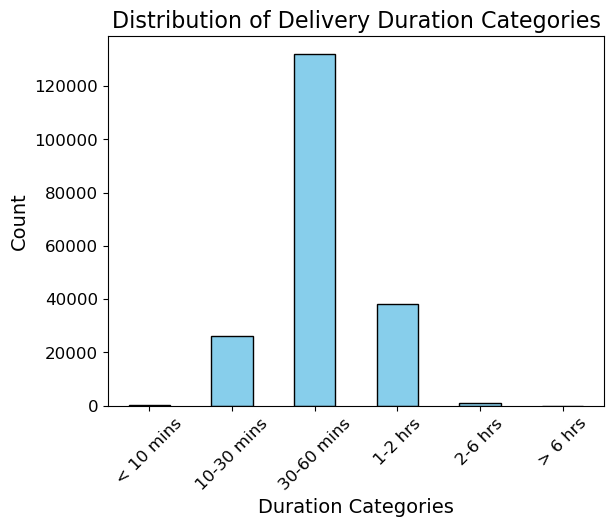

In [21]:
bins = [0, 600, 1800, 3600, 7200, 21600, 57032]
labels = [
    "< 10 mins", "10-30 mins", "30-60 mins", "1-2 hrs", "2-6 hrs", "> 6 hrs"
]

df["duration_cat"] = pd.cut(df["duration"], bins=bins, labels=labels, right=True)

print(df["duration_cat"].value_counts())

df["duration_cat"].value_counts().sort_index().plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Duration Categories")
plt.ylabel("Count")
plt.title("Distribution of Delivery Duration Categories")
plt.xticks(rotation=45)
plt.show()

#### Create a Test Set

1. Random Shuffling (shuffle_and_split_data)
   - Simple and easy to implement. Ensures randomness in the train-test split.
   - Not deterministic (unless set a global random seed). Doesn't handle imbalanced data or ensure representative splits for important features or target distributions.
   - Best use case is when the dataset is balanced and no specific column needs to be considered for splitting.
2. Hash-Based Splitting (split_data_with_id_hash)
   - Deterministic: Ensures the same split every time yas long as the ID column remains unchanged.
   - Useful in scenarios where data leakage might occur due to ordering or time-based patterns.
  
  Note: it is based on Python's `hash()` function, which is randomly "salted", to prevent some denial-of-service attacks. To remove this randomness, the solution is to set the `PYTHONHASHSEED` environment variable to `"0"` _before_ Python even starts up. Nothing will happen if you do it after that. Luckily, if you're running this notebook on Colab, the variable is already set for you.
  
  ***crc32 generates a pseudorandom 32-bit integer based on the input. This pseudorandom behavior ensures that IDs are distributed relatively evenly and unpredictably across the hash space.

1. Scikit-Learn's train_test_split
   - Allows stratification if the target variable is imbalanced
   - Randomness can be controlled with random_state
   - A quick and reliable method, especially if stratification is needed.

2. Scikit-Learn's StratifiedShuffleSplit
   - Works well for datasets where specific features need to be proportionally represented.
   - Use when the target variable or specific features are imbalanced, and stratification is necessary.

Although there are several ways to split data, random splitting can result in future data (e.g., from February) being assigned to the training set while earlier data (e.g., from January) ends up in the test set. To avoid data leakage, it is essential to split the data chronologically. Sort the dataset by the created_at field to ensure the correct chronological order before splitting.

In [22]:
print(df["order_month"].value_counts() / len(df["order_month"]))

order_month
2    0.653129
1    0.346871
Name: count, dtype: float64


In [23]:
# Sort the dataset by created_at to maintain chronological order
df = df.sort_values("created_at")

df.drop(columns=["created_at", "actual_delivery_time"], inplace=True)

In [24]:
from sklearn.model_selection import train_test_split

def duration_cat_proportions(data):
    return data["duration_cat"].value_counts(normalize=True)

# store results for different split ratios
results = {}

split_ratios = [0.2, 0.25, 0.3, 0.35]

for test_size in split_ratios:

    train_set, test_set = train_test_split(df, test_size=test_size, random_state=42)
    
    overall_props = duration_cat_proportions(df)
    train_props = duration_cat_proportions(train_set)
    test_props = duration_cat_proportions(test_set)
    
    # store the results in a DataFrame for the current split ratio
    compare_props = pd.DataFrame({
        "Overall %": overall_props * 100,
        f"Train {int((1-test_size)*100)}%": train_props * 100,
        f"Test {int(test_size*100)}%": test_props * 100
    }).fillna(0).sort_index()
    
    # error calculations
    compare_props[f"Train {int((1-test_size)*100)}% Error"] = (train_props / overall_props - 1).fillna(0) * 100
    compare_props[f"Test {int(test_size*100)}% Error"] = (test_props / overall_props - 1).fillna(0) * 100
    
    results[f"Split {int(test_size*100)}%"] = compare_props

for split, df_props in results.items():
    print(f"Results for {split}:")
    print(df_props.round(2))
    print("\n" + "-"*50 + "\n")

Results for Split 20%:
              Overall %  Train 80%  Test 20%  Train 80% Error  Test 20% Error
duration_cat                                                                 
< 10 mins          0.01       0.01      0.02           -16.67           66.66
10-30 mins        13.14      13.13     13.19            -0.08            0.33
30-60 mins        66.97      66.92     67.18            -0.08            0.31
1-2 hrs           19.32      19.40     19.00             0.41           -1.63
2-6 hrs            0.54       0.53      0.59            -2.11            8.45
> 6 hrs            0.01       0.01      0.02           -14.77           59.09

--------------------------------------------------

Results for Split 25%:
              Overall %  Train 75%  Test 25%  Train 75% Error  Test 25% Error
duration_cat                                                                 
< 10 mins          0.01       0.01      0.02           -11.11           33.33
10-30 mins        13.14      13.13     13.2

A 35% test ratio yields the lowest error rate for both train and test datasets in terms of overall duration distribution

In [25]:
split_index = int(len(df) * 0.65)
train_set = df.iloc[:split_index]
test_set = df.iloc[split_index:]

for set_ in (train_set, test_set):
    set_.drop("duration_cat", axis=1, inplace=True)

/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/3166291044.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("duration_cat", axis=1, inplace=True)
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/3166291044.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("duration_cat", axis=1, inplace=True)


In [26]:
print(train_set.shape)
train_set.isnull().sum()

(128326, 18)


market_id                                        618
store_id                                           0
store_primary_category                          3135
order_protocol                                   631
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_onshift_dashers                           9723
total_busy_dashers                              9723
total_outstanding_orders                        9723
estimated_order_place_duration                     0
estimated_store_to_consumer_driving_duration     507
duration                                           3
order_hour                                         0
order_day                                          0
order_month                                        0
dtype: int64

In [27]:
print(test_set.shape)
test_set.isnull().sum()

(69099, 18)


market_id                                        369
store_id                                           0
store_primary_category                          1625
order_protocol                                   364
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_onshift_dashers                           6538
total_busy_dashers                              6538
total_outstanding_orders                        6538
estimated_order_place_duration                     0
estimated_store_to_consumer_driving_duration      19
duration                                           4
order_hour                                         0
order_day                                          0
order_month                                        0
dtype: int64

#### Correlations

In [28]:
DoorDash = train_set.copy()

Note: since Pandas 2.0.0, the `numeric_only` argument defaults to `False`, so we need to set it explicitly to True to avoid an error.

In [29]:
corr_matrix = DoorDash.corr(numeric_only=True)
corr_matrix["duration"].sort_values(ascending=False)

duration                                        1.000000
estimated_store_to_consumer_driving_duration    0.225140
subtotal                                        0.200733
total_outstanding_orders                        0.177937
num_distinct_items                              0.144853
max_item_price                                  0.126527
total_items                                     0.104437
estimated_order_place_duration                  0.094591
order_month                                     0.079654
total_busy_dashers                              0.077302
total_onshift_dashers                           0.059009
min_item_price                                  0.016655
store_id                                       -0.008952
order_day                                      -0.026437
market_id                                      -0.034031
order_protocol                                 -0.064091
order_hour                                     -0.165583
Name: duration, dtype: float64

Most variables have low correlation.

Top variables coorelated with duration:
- estimated_store_to_consumer_driving_duration: the time taken to drive from the store to the consumer is a key factor in the total delivery time. This is expected, as this component directly contributes to the total duration. 
- subtotal (0.201): larger order values (likely from larger or more complex orders) are associated with longer delivery durations. but consider interactions with other variables like total_items or num_distinct_items.

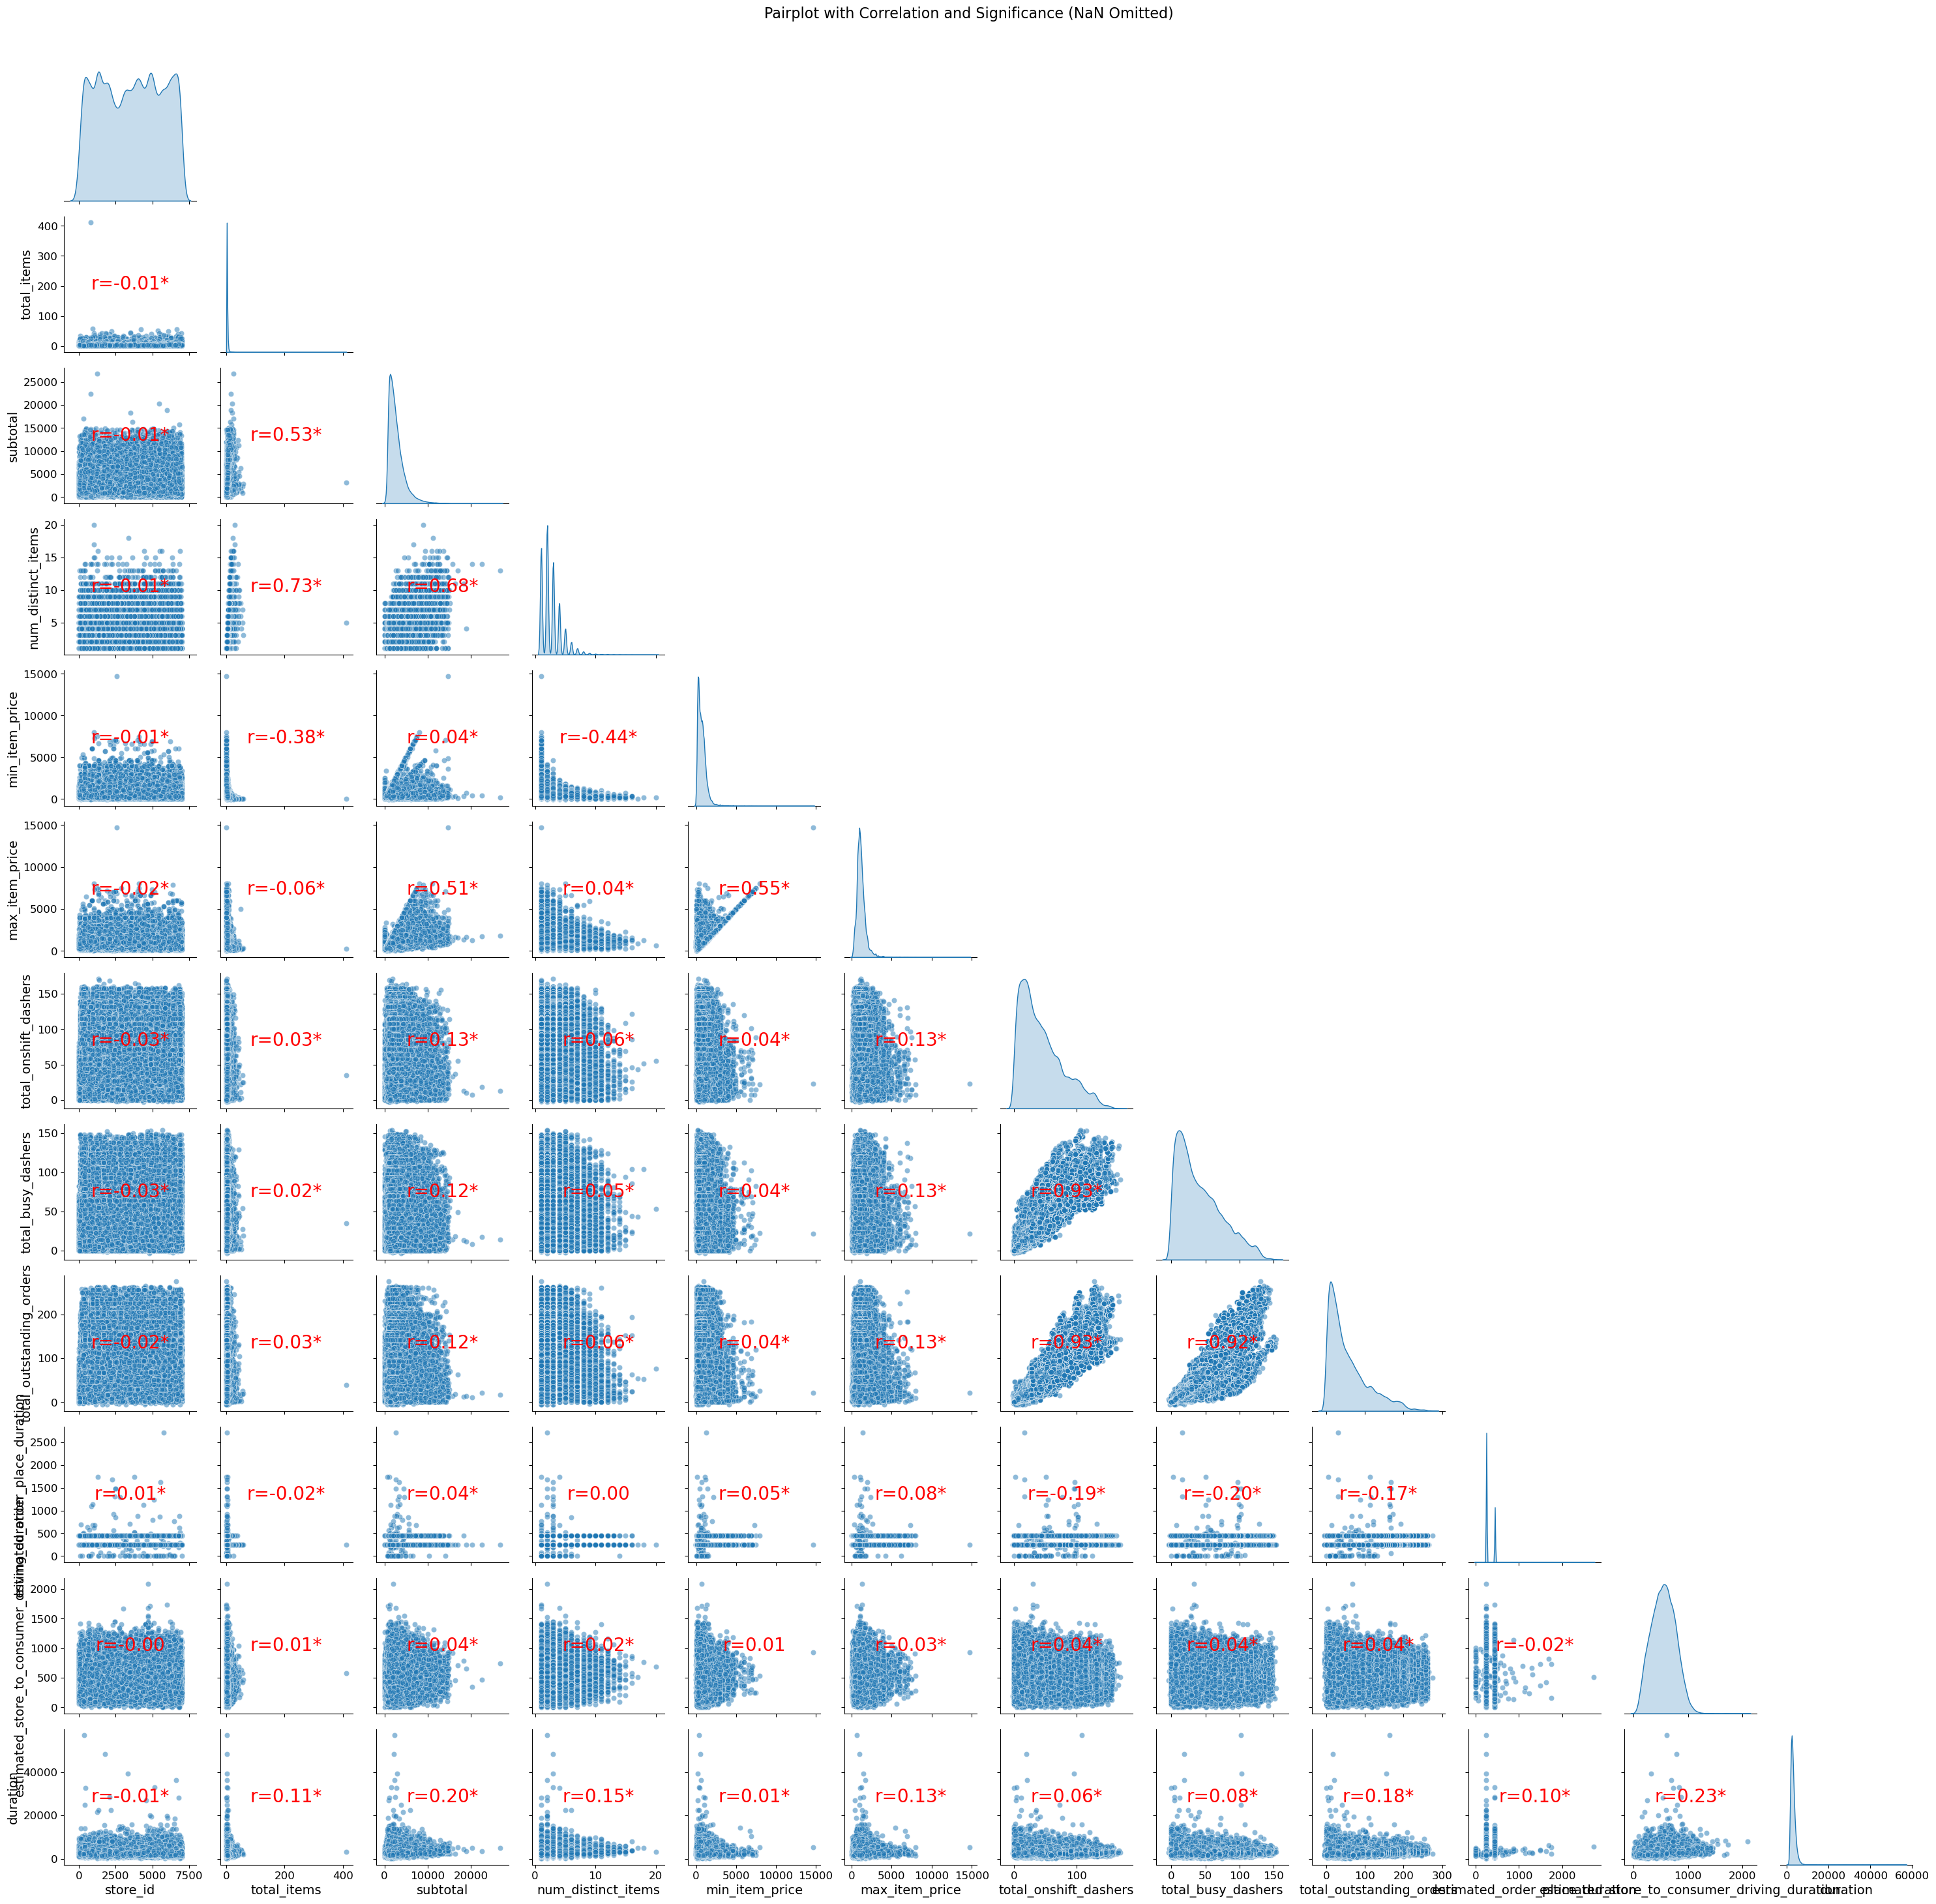

In [30]:
from pandas.plotting import scatter_matrix
from scipy.stats import pearsonr

cat_col = ["market_id", "order_protocol", "order_hour", "order_day", "order_month"]

def annotate_corr(x, y, **kwargs):
    # drop NaN values for correlation calculation
    valid_mask = pd.notnull(x) & pd.notnull(y)
    if valid_mask.sum() > 1:  # ensure there are enough valid points for correlation
        r, p = pearsonr(x[valid_mask], y[valid_mask])  
        ax = plt.gca()
        significance = "*" if p < 0.05 else ""  # add asterisk if significant
        ax.annotate(f"r={r:.2f}{significance}", xy=(0.5, 0.5), xycoords="axes fraction",
                    ha="center", va="center", fontsize=20, color="red")
    else:
        # handle cases with insufficient valid data
        ax = plt.gca()
        ax.annotate("N/A", xy=(0.5, 0.5), xycoords="axes fraction",
                    ha="center", va="center", fontsize=10, color="gray")

numeric_columns = DoorDash.drop(columns=cat_col).select_dtypes(include=["number"])
cleaned_data = numeric_columns.dropna()

g = sns.PairGrid(cleaned_data, diag_sharey=False, corner=True)

g.map_lower(sns.scatterplot, alpha=0.5)  # Scatter plots for lower triangle
g.map_diag(sns.kdeplot, fill=True)       # KDE plots for diagonal
g.map_lower(annotate_corr)               # Add correlation annotations

plt.subplots_adjust(top=0.95)
g.fig.suptitle("Pairplot with Correlation and Significance (NaN Omitted)", fontsize=16)
plt.show()

High Positive Correlations

total_onshift_dashers, total_busy_dashers
- subtotal vs. max_item_price (r = 0.73): higher subtotal values are strongly associated with higher maximum item prices, as expected for larger or premium orders.
- subtotal vs. num_distinct_items (r = 0.55): Shows that as the number of distinct items increases, the subtotal also rises. This is logical as more variety typically results in a higher order value.
- total_items vs. subtotal (r = 0.38): orders with more total items tend to have higher subtotals, though the relationship is not perfectly linear.
- total_busy_dashers vs. total_outstanding_orders (r = 0.44): the number of busy dashers tends to increase as the number of outstanding orders rises, reflecting operational congestion.

/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/452333995.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=DoorDash, x=col, y="duration", palette="Set3")  # Use the entire DataFrame
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/452333995.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=DoorDash, x=col, y="duration", palette="Set3")  # Use the entire DataFrame
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/452333995.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=D

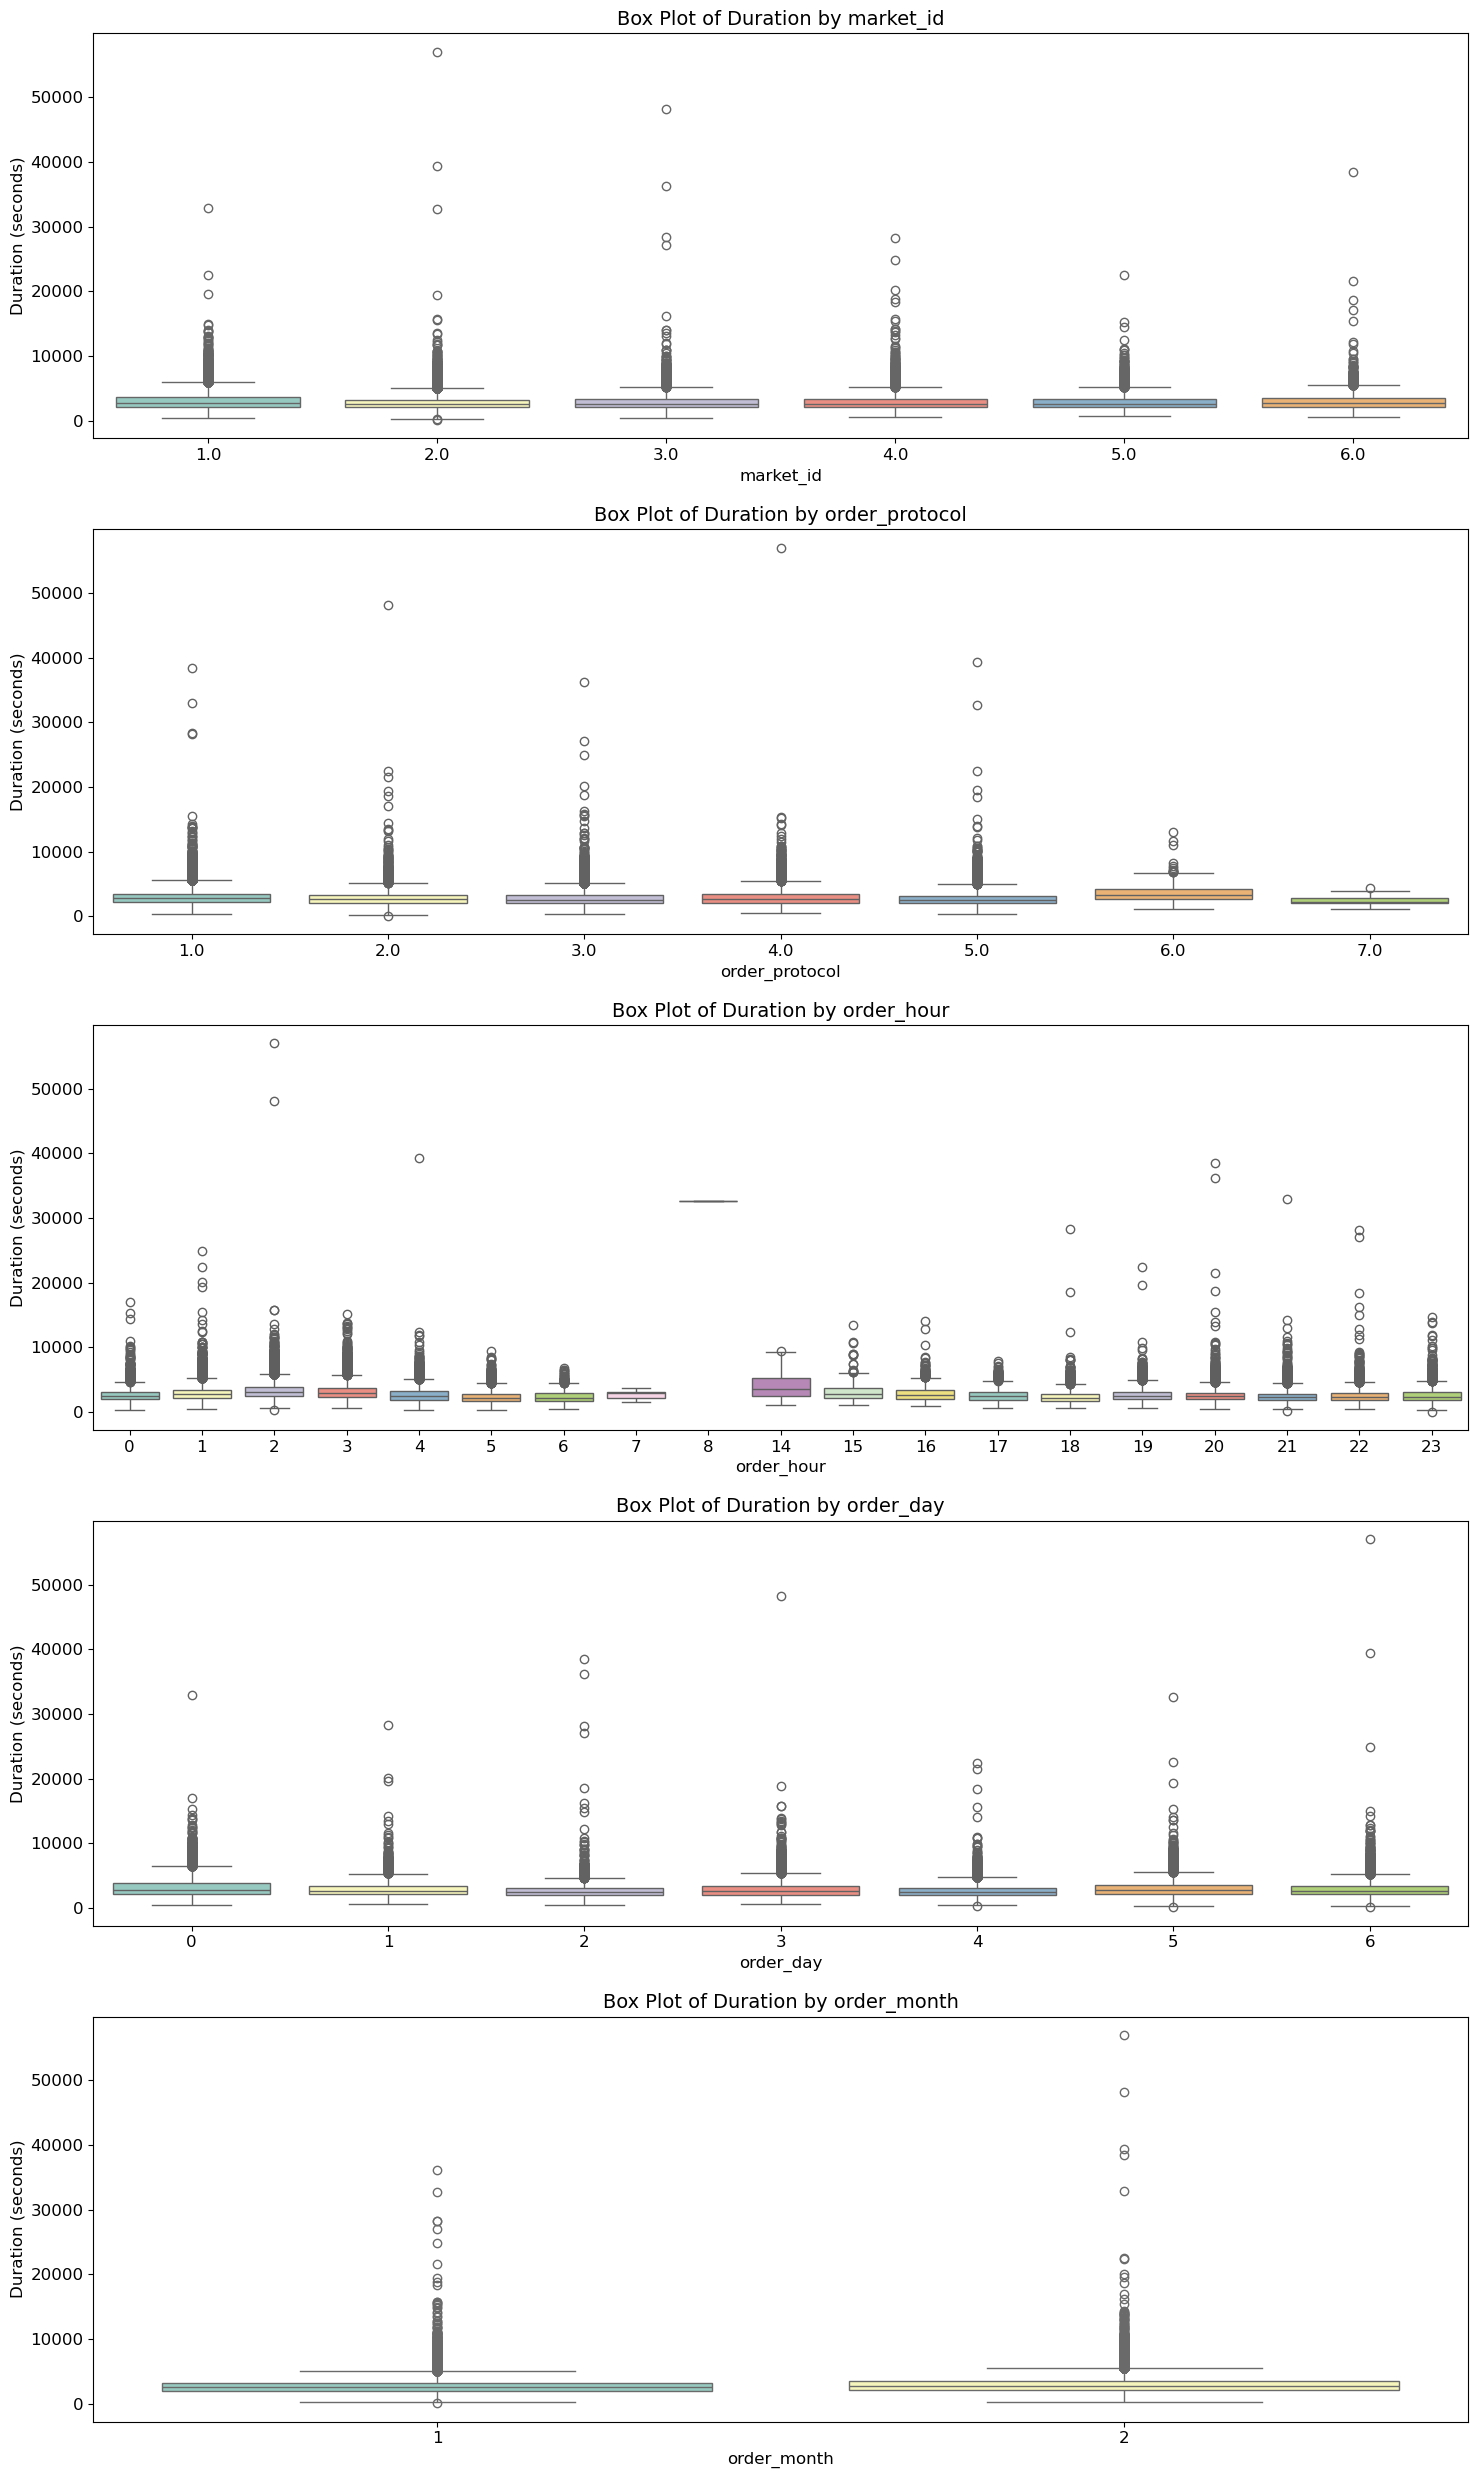

In [31]:
# Create box plots for each categorical column
plt.figure(figsize=(15, 5 * len(cat_col)))  # Adjust the figure size based on the number of plots
for i, col in enumerate(cat_col, 1):
    plt.subplot(len(cat_col), 1, i)  # Create subplots for each categorical column
    sns.boxplot(data=DoorDash, x=col, y="duration", palette="Set3")  # Use the entire DataFrame
    plt.title(f"Box Plot of Duration by {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Duration (seconds)", fontsize=12)
    plt.xticks()  

plt.tight_layout()
plt.show()

Due to ourliers, it's hard to see differences between levels within a catgorical variable.

### Prepare the Data for Machine Learning Algorithms
#### Data Cleaning
3 options are listed to handle the NaN values:

```python
housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2: axis=1 (rows), axis=0 (columns)

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

I use median imputation (or mean for normally distributed data) for numerical features, and for categorical features, use the mode to fill missing values. As dropping rows with missing values removes potentially useful information from the dataset, reducing the size of the data available for analysis or modeling. Imputation allows the feature to remain in the dataset, preserving its potential contribution to the model.

In [32]:
from sklearn.impute import SimpleImputer

# separate numeric and categorical columns
num_na_cols = ["estimated_store_to_consumer_driving_duration", "total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders", "duration"]
cat_na_cols = ["market_id", "store_primary_category", "order_protocol"]

# numeric columns
imputer = SimpleImputer(strategy = "median")
DoorDash[num_na_cols] = imputer.fit_transform(DoorDash[num_na_cols])
# apply to test_set
test_set[num_na_cols] = imputer.fit_transform(test_set[num_na_cols])

# categorical columns
imputer = SimpleImputer(strategy = "most_frequent")
DoorDash[cat_na_cols] = imputer.fit_transform(DoorDash[cat_na_cols])
# apply to test_set
test_set[cat_na_cols] = imputer.fit_transform(test_set[cat_na_cols])

print(DoorDash.isnull().sum())

market_id                                       0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
duration                                        0
order_hour                                      0
order_day                                       0
order_month                                     0
dtype: int64


/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/2194667619.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[num_na_cols] = imputer.fit_transform(test_set[num_na_cols])
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/2194667619.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[cat_na_cols] = imputer.fit_transform(test_set[cat_na_cols])


Replace negative values with column medians for columns whose minimum are negative.

In [33]:
neg_cols = ["min_item_price", "total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders"]

for col in neg_cols:
    median_value = DoorDash.loc[DoorDash[col] >= 0, col].median()
    
    DoorDash.loc[DoorDash[col] < 0, col] = median_value

# min_item_price should > 0, replace zeros in min_item_price with the median
median_value = DoorDash.loc[DoorDash["min_item_price"] > 0, "min_item_price"].median()
DoorDash.loc[DoorDash["min_item_price"] == 0, "min_item_price"] = median_value

DoorDash[neg_cols].describe()

# apply to test_set
for col in neg_cols:
    median_value = test_set.loc[test_set[col] >= 0, col].median()
    
    test_set.loc[test_set[col] < 0, col] = median_value
median_value = test_set.loc[test_set["min_item_price"] > 0, "min_item_price"].median()
test_set.loc[test_set["min_item_price"] == 0, "min_item_price"] = median_value

#### Experimenting with Attribute Combinations

To capture interactions, groupings, or transformations of features to improve the predictive power of the model for duration, 
- subtotal_per_item = subtotal / total_items: average price level of that order
- complexity = num_distinct_items / total_items: Higher values suggest more diverse items, which could increase preparation time.
- demand_supply_ratio = total_outstanding_orders / total_onshift_dashers: the relationship between outstanding orders and all available dashers.
- dasher_utilization = total_busy_dashers / total_onshift_dashers: Measures the proportion of dashers who are currently busy.
- active_workload = total_outstanding_orders / total_busy_dashers: Measures how many orders each busy dasher is currently managing. 
- market_congestion = (total_outstanding_orders - total_busy_dashers) / total_onshift_dashers: Measures how saturated the local market is. Numerator captures the number of orders waiting for assignment, divided by total_onshift_dashers indicates how strained the dasher network is.

In [34]:
DoorDash["subtotal_per_item"] = DoorDash["subtotal"] / DoorDash["total_items"]
DoorDash["complexity"] = DoorDash["num_distinct_items"] / DoorDash["total_items"]
DoorDash["demand_supply_ratio"] = DoorDash["total_outstanding_orders"] / DoorDash["total_onshift_dashers"]
DoorDash["active_workload"] = DoorDash["total_outstanding_orders"] / DoorDash["total_busy_dashers"]
DoorDash["dasher_utilization"] = DoorDash["total_busy_dashers"] / DoorDash["total_onshift_dashers"]
DoorDash["market_congestion"] = (DoorDash["total_outstanding_orders"] - DoorDash["total_busy_dashers"]) / DoorDash["total_onshift_dashers"]

To fix inf or NaN values in derived columns, we need to replace these invalid values with their column medians.

In [35]:
derived_cols = ["demand_supply_ratio", "active_workload", "dasher_utilization", "market_congestion"]

# replace inf and -inf with NaN
DoorDash[derived_cols] = DoorDash[derived_cols].replace([np.inf, -np.inf], np.nan)

# impute with the column median
for col in derived_cols:
    median_value = DoorDash[col].median(skipna=True)  # skip NaN when calculating the median
    DoorDash[col].fillna(median_value, inplace=True)

print(DoorDash[derived_cols].isnull().sum())

demand_supply_ratio    0
active_workload        0
dasher_utilization     0
market_congestion      0
dtype: int64


/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/4223527780.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  DoorDash[col].fillna(median_value, inplace=True)
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/4223527780.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [36]:
corr_matrix = DoorDash.corr(numeric_only=True)
corr_matrix["duration"].sort_values(ascending=False)

duration                                        1.000000
demand_supply_ratio                             0.298859
active_workload                                 0.280536
market_congestion                               0.226728
estimated_store_to_consumer_driving_duration    0.224845
subtotal                                        0.200733
total_outstanding_orders                        0.168803
num_distinct_items                              0.144852
max_item_price                                  0.126528
total_items                                     0.104436
estimated_order_place_duration                  0.094593
order_month                                     0.079648
subtotal_per_item                               0.074209
total_busy_dashers                              0.073141
total_onshift_dashers                           0.055727
dasher_utilization                              0.046609
min_item_price                                  0.016154
store_id                       

Since demand_supply_ratio has the highest correlation with the target, keep it and remove total_outstanding_orders, total_onshift_dashers, total_busy_dashers, as they can be aggregated to avoid collinearity.

In [37]:
DoorDash.drop(columns=["total_outstanding_orders", "total_onshift_dashers", "total_busy_dashers", "subtotal_per_item", 
                       "complexity", "active_workload", "dasher_utilization", "market_congestion"], inplace=True)

# apply to test_set
test_set["demand_supply_ratio"] = test_set["total_outstanding_orders"] / test_set["total_onshift_dashers"]
test_set.drop(columns=["total_outstanding_orders", "total_onshift_dashers", "total_busy_dashers"], inplace=True)

# replace inf and -inf, NaN with median
test_set["demand_supply_ratio"] = test_set["demand_supply_ratio"].replace([np.inf, -np.inf], np.nan)
median_value = test_set["demand_supply_ratio"].median(skipna=True)
test_set["demand_supply_ratio"].fillna(median_value, inplace=True)

/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/362956311.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["demand_supply_ratio"] = test_set["total_outstanding_orders"] / test_set["total_onshift_dashers"]
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/362956311.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.drop(columns=["total_outstanding_orders", "total_onshift_dashers", "total_busy_dashers"], inplace=True)
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/362956311.py:9: SettingWithCop

Let's separate the target (note that `DoorDash.drop()` creates a copy of `DoorDash_X` without the column, it doesn't actually modify `DoorDash` itself, unless you pass `inplace=True`):

In [38]:
DoorDash_X = DoorDash.drop("duration", axis=1)
DoorDash_y = DoorDash["duration"].copy()

Now let's drop some outliers:

In [39]:
from sklearn.ensemble import IsolationForest

new_cat_cols = ["market_id", "store_id", "store_primary_category", "order_protocol", "order_hour", "order_day", "order_month"]

# exclude categorical columns
numeric_data = DoorDash_X.drop(columns=new_cat_cols)

# fit on numeric data only
isolation_forest = IsolationForest(random_state=42, contamination="auto")
outlier_pred = isolation_forest.fit_predict(numeric_data)

outlier_pred

array([1, 1, 1, ..., 1, 1, 1])

Use the outlier_pred array as a mask to filter out rows marked as outliers (-1) to remove them.

In [40]:
print(DoorDash_X.shape)
print(DoorDash_X.shape)

DoorDash_X = DoorDash_X.iloc[outlier_pred == 1]
DoorDash_y = DoorDash_y.iloc[outlier_pred == 1]
print("after removing outliers")
print(DoorDash_X.shape)
print(DoorDash_X.shape)

(128326, 15)
(128326, 15)
after removing outliers
(109362, 15)
(109362, 15)


#### Handling Text and Categorical Attributes

***By default, the `OneHotEncoder` class returns a sparse array. A sparse matrix stores only the non-zero elements (like 1 in one-hot encoding) to save memory, whereas a dense array explicitly stores all elements, including zeroes.

In [41]:
print(DoorDash_X["order_hour"].value_counts())
print(DoorDash_X["order_day"].value_counts())
print(DoorDash_X["store_primary_category"].value_counts())

order_hour
2     19505
1     14799
3     14427
20     9375
4      8296
19     7722
0      6982
21     6982
22     5331
23     4837
5      3900
18     2915
17     1961
16     1178
6       858
15      263
14       23
7         7
8         1
Name: count, dtype: int64
order_day
5    21572
6    20726
4    17722
3    16297
2    12010
0    10816
1    10219
Name: count, dtype: int64
store_primary_category
american             13056
mexican               9884
pizza                 9660
burger                6753
sandwich              5957
chinese               5338
dessert               4848
japanese              4517
indian                4029
thai                  3947
vietnamese            3746
fast                  3549
italian               3546
mediterranean         3188
breakfast             3083
other                 2410
salad                 2163
greek                 1922
seafood               1453
barbecue              1356
asian                 1354
cafe                  1222
sushi

Group the order_hour values into broader time ranges:
- Night (0–5): Late night and early morning.
- Morning (6–11): Breakfast and morning.
- Afternoon (12–17): Lunch and early afternoon.
- Evening (18–23): Dinner and late evening.

In [42]:
def classify_order_hour(hour):
    if 0 <= hour <= 5:
        return "Night"
    elif 6 <= hour <= 11:
        return "Morning"
    elif 12 <= hour <= 17:
        return "Afternoon"
    else:
        return "Evening"

DoorDash_X["order_hour"] = DoorDash_X["order_hour"].apply(classify_order_hour)
print(DoorDash_X["order_hour"].value_counts())

# apply to test
test_set["order_hour"] = test_set["order_hour"].apply(classify_order_hour)

order_hour
Night        67909
Evening      37162
Afternoon     3425
Morning        866
Name: count, dtype: int64


/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/446266650.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["order_hour"] = test_set["order_hour"].apply(classify_order_hour)


Group the order_day values into weekday and weekend:
- Weekday (0–4): Monday through Friday.
- Weekend (5–6): Saturday and Sunday.

In [43]:
# order_day
def classify_order_day(day):
    if day in [0, 1, 2, 3, 4]:
        return "Weekday"
    else:
        return "Weekend"

DoorDash_X["order_day"] = DoorDash_X["order_day"].apply(classify_order_day)
print(DoorDash_X["order_day"].value_counts())

# apply to test
test_set["order_day"] = test_set["order_day"].apply(classify_order_hour)

order_day
Weekday    67064
Weekend    42298
Name: count, dtype: int64


/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/3776616789.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["order_day"] = test_set["order_day"].apply(classify_order_hour)


Group store_primary_category into similar broader categories:
- Asian: Chinese restaurants, Japanese cuisine, Thai food, Vietnamese establishments, Korean restaurants, General Asian restaurants, Dim sum specialists, Burmese cuisine, Malaysian food, Filipino restaurants, Singaporean cuisine, Indonesian food, Sushi restaurants, Bubble tea shops
- European: Italian restaurants, French cuisine, British food, German restaurants, Irish pubs/restaurants, Spanish cuisine, General European establishments, Belgian restaurants, Russian food, Tapas bars
- Mediterranean&Mid_Eastern: Mediterranean restaurants, Middle Eastern cuisine, Persian food, Turkish restaurants, Lebanese establishments, Moroccan cuisine, Greek food, Afghan restaurants
- Latin_American: Mexican restaurants, General Latin American cuisine, Brazilian food, Peruvian restaurants, Caribbean establishments, Argentine cuisine
- American&Western: American traditional cuisine, Burger restaurants, Sandwich shops, Fast food establishments, Barbecue restaurants, Southern cuisine, Cajun food, Comfort food restaurants
- Indian: Indian restaurants, Pakistani cuisine, Nepalese food
- Specialty: Pizza restaurants, Dessert shops, Breakfast/brunch places, Salad restaurants, Seafood establishments, Cafes, Alcohol vendors, Smoothie shops, Catering services, Pasta specialists, Soup restaurants, Cheese shops
- Dietary_Spec: Vegetarian restaurants, Vegan establishments, Gluten-free specialists, Kosher restaurants
- Other: General 'other' category, Convenience stores, Gastropubs, Alcohol plus food establishments, Hawaiian restaurants, African cuisine, Ethiopian restaurants, Steakhouses

In [44]:
def reclassify_food_categories(category):

    category_mapping = {
        # Asian cuisines
        'chinese': 'Asian',
        'japanese': 'Asian',
        'thai': 'Asian',
        'vietnamese': 'Asian',
        'korean': 'Asian',
        'asian': 'Asian',
        'dim-sum': 'Asian',
        'burmese': 'Asian',
        'malaysian': 'Asian',
        'filipino': 'Asian',
        'singaporean': 'Asian',
        'indonesian': 'Asian',
        'sushi': 'Asian',
        'bubble-tea': 'Asian',
        
        # European cuisines
        'italian': 'European',
        'french': 'European',
        'british': 'European',
        'german': 'European',
        'irish': 'European',
        'spanish': 'European',
        'european': 'European',
        'belgian': 'European',
        'russian': 'European',
        'tapas': 'European',
        
        # Middle Eastern & Mediterranean
        'mediterranean': 'Middle Eastern & Mediterranean',
        'middle-eastern': 'Middle Eastern & Mediterranean',
        'persian': 'Middle Eastern & Mediterranean',
        'turkish': 'Middle Eastern & Mediterranean',
        'lebanese': 'Middle Eastern & Mediterranean',
        'moroccan': 'Middle Eastern & Mediterranean',
        'greek': 'Middle Eastern & Mediterranean',
        'afghan': 'Middle Eastern & Mediterranean',
        
        # Latin American
        'mexican': 'Latin American',
        'latin-american': 'Latin American',
        'brazilian': 'Latin American',
        'peruvian': 'Latin American',
        'caribbean': 'Latin American',
        'argentine': 'Latin American',
        
        # American & Western
        'american': 'American',
        'burger': 'American',
        'sandwich': 'American',
        'fast': 'American',
        'barbecue': 'American',
        'southern': 'American',
        'cajun': 'American',
        'comfort-food': 'American',
        
        # Indian Subcontinent
        'indian': 'Indian Subcontinent',
        'pakistani': 'Indian Subcontinent',
        'nepalese': 'Indian Subcontinent',
        
        # Specialty Categories
        'pizza': 'Pizza',
        'dessert': 'Specialty',
        'breakfast': 'Specialty',
        'salad': 'Specialty',
        'seafood': 'Specialty',
        'cafe': 'Specialty',
        'alcohol': 'Specialty',
        'smoothie': 'Specialty',
        'catering': 'Specialty',
        'pasta': 'Specialty',
        'soup': 'Specialty',
        'cheese': 'Specialty',
        
        # Dietary Specific
        'vegetarian': 'Dietary Specific',
        'vegan': 'Dietary Specific',
        'gluten-free': 'Dietary Specific',
        'kosher': 'Dietary Specific',
        
        # Other
        'other': 'Other',
        'convenience-store': 'Other',
        'gastropub': 'Other',
        'alcohol-plus-food': 'Other',
        'hawaiian': 'Other',
        'african': 'Other',
        'ethiopian': 'Other',
        'steak': 'Other'
    }
    
    # convert to lowercase and map to broader category
    category = str(category).lower()
    return category_mapping.get(category, 'Other')

DoorDash_X["store_primary_category"] = DoorDash_X["store_primary_category"].apply(reclassify_food_categories)
print(DoorDash_X["store_primary_category"].value_counts())

# apply to test
test_set["store_primary_category"] = test_set["store_primary_category"].apply(reclassify_food_categories)

store_primary_category
American                          30920
Asian                             22413
Specialty                         16035
Latin American                    10645
Pizza                              9660
Middle Eastern & Mediterranean     6477
Indian Subcontinent                4290
Other                              4111
European                           4075
Dietary Specific                    736
Name: count, dtype: int64


/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/1243126211.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["store_primary_category"] = test_set["store_primary_category"].apply(reclassify_food_categories)


- Drop store_id as store_primary_category provides sufficient representation of the store's characteristics.
- Drop order_month as there is only one level in test_set

In [45]:
DoorDash_X.drop(columns=["store_id", "order_month"], inplace=True)
test_set.drop(columns=["store_id", "order_month"], inplace=True)

/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_90243/3341736092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.drop(columns=["store_id", "order_month"], inplace=True)


#### Encoding

1. Method 1: Using pandas get_dummies
2. Method 2: Using OneHotEncoder

In [46]:
from sklearn.preprocessing import OneHotEncoder

X_train = DoorDash_X.copy()
y_train = DoorDash_y.copy()
X_test = test_set.drop(columns=["duration"])
y_test = test_set["duration"]

# define numerical columns
cat_cols = ["market_id", "order_protocol", "store_primary_category", "order_hour", "order_day"]
num_cols = [col for col in X_train.columns if col not in cat_cols]

# setup the encoder
# ensured the encoder handles unseen categories in the test set with handle_unknown='ignore'
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

encoded_train = cat_encoder.fit_transform(X_train[cat_cols])
encoded_train_df = pd.DataFrame(
    encoded_train, 
    columns=cat_encoder.get_feature_names_out(cat_cols),
    index=X_train.index
)

encoded_test = cat_encoder.transform(X_test[cat_cols])
encoded_test_df = pd.DataFrame(
    encoded_test, 
    columns=cat_encoder.get_feature_names_out(cat_cols),
    index=X_test.index
)

num_cols = [col for col in X_train.columns if col not in cat_cols]

X_train_encoded = pd.concat([X_train[num_cols], encoded_train_df], axis=1)
X_test_encoded = pd.concat([X_test[num_cols], encoded_test_df], axis=1)

print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")

X_train_encoded shape: (109362, 32)
X_test_encoded shape: (69099, 32)


/Users/chenshuxi/miniconda3/envs/0207_causal/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Feature Scaling
1. MinMaxScaler: Ideal for algorithms sensitive to feature magnitudes (e.g., k-NN, SVM).
2. StandardScaler: Preferred for algorithms assuming normal distributions (e.g., PCA, Logistic Regression).

In [47]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

X_train_encoded_std_scaled = pd.DataFrame(
    X_scaler.fit_transform(X_train_encoded),
    columns=X_train_encoded.columns,
    index=X_train_encoded.index
)

X_test_encoded_std_scaled = pd.DataFrame(
    X_scaler.transform(X_test_encoded),
    columns=X_test_encoded.columns,
    index=X_test_encoded.index
)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

#### Radial Basis Function (RBF) kernel 

A mathematical function used to measure the similarity between data points.

K(x,y) = exp(−γ⋅∣∣x−y∣∣^2)

**γ (gamma): Controls how rapidly similarity decreases with distance. Higher values make the kernel more sensitive to differences in variables.

The goal is to calculate how similar each district's median age of houses (in housing_median_age) is to the reference age of 35.

In [48]:
# from sklearn.metrics.pairwise import rbf_kernel

# # compute RBF kernel on numerical features
# similarity_matrix = rbf_kernel(X_test_encoded_std_scaled[num_cols], gamma = 0.1)

# print(similarity_matrix.shape)

Since several data are right skewed, I use log transformation to fix them.

In [49]:
from sklearn.preprocessing import FunctionTransformer

# add a small constant to avoid log(0)
epsilon = 1e-9

log_transformer = FunctionTransformer(
    func=lambda X: np.log(X + epsilon),
    inverse_func=lambda X: np.exp(X) - epsilon 
)

X_train_log_scaled = log_transformer.transform(X_train_encoded_std_scaled[num_cols])
X_test_log_scaled = log_transformer.transform(X_test_encoded_std_scaled[num_cols])

X_train_log_scaled_df = pd.DataFrame(
    X_train_log_scaled,
    columns=num_cols,
    index=X_train_encoded_std_scaled.index
)
X_test_log_scaled_df = pd.DataFrame(
    X_test_log_scaled,
    columns=num_cols,
    index=X_test_encoded_std_scaled.index
)

X_train_encoded_std_scaled.update(X_train_log_scaled_df)
X_test_encoded_std_scaled.update(X_test_log_scaled_df)

print(X_train_encoded_std_scaled.head())
print(X_test_encoded_std_scaled.head())

        total_items  subtotal  num_distinct_items  min_item_price  \
43519     -0.505853 -1.021649           -0.348152       -1.096326   
148754    -0.505853 -1.318474           -0.348152       -1.156453   
187014    -1.835937 -0.369119           -0.719865       -0.520108   
10265     -1.835937 -1.104728           -0.719865       -1.031188   
188797    -1.835937 -1.209584           -1.183123       -1.331824   

        max_item_price  estimated_order_place_duration  \
43519        -0.698386                       -0.586464   
148754       -2.036108                       -0.586464   
187014       -1.362329                       -0.586464   
10265        -1.814794                       -0.586464   
188797       -2.355784                       -0.586464   

        estimated_store_to_consumer_driving_duration  demand_supply_ratio  \
43519                                      -0.371897            -1.807858   
148754                                     -0.395870            -1.807858   
18701

/Users/chenshuxi/miniconda3/envs/0207_causal/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/chenshuxi/miniconda3/envs/0207_causal/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


#### VIF test

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):

    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [
        variance_inflation_factor(dataframe.values, i) 
        for i in range(dataframe.shape[1])
    ]
    return vif_data

X_train_vif = pd.DataFrame(X_train_encoded_std_scaled, columns=X_train_encoded.columns)

vif_results = calculate_vif(X_train_vif)
print(vif_results)

                                              Feature       VIF
0                                         total_items  3.190032
1                                            subtotal  1.787797
2                                  num_distinct_items  3.334789
3                                      min_item_price  1.674597
4                                      max_item_price  1.655999
5                      estimated_order_place_duration  5.397710
6        estimated_store_to_consumer_driving_duration  1.484894
7                                 demand_supply_ratio  1.463696
8                                       market_id_2.0  1.892232
9                                       market_id_3.0  1.446270
10                                      market_id_4.0  1.857750
11                                      market_id_5.0  1.367050
12                                      market_id_6.0  1.316614
13                                 order_protocol_2.0  3.302091
14                                 order

No columns need to remove, all VIF < 10

### Feature Selection
1. Forward Selection
2. Backward Selection
3. Recursive Feature Elimination (RFE)
4. Lasso regression to penalize less important features
5. Random Forest importance scores

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

linear_model = LinearRegression()
lasso_model = Lasso(alpha=0.01, random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# for storing results
feature_selection_results = {}

# Forward 
forward_selector = SequentialFeatureSelector(
    linear_model,
    n_features_to_select="auto",
    direction="forward",
    scoring="r2",
    cv=5,
    n_jobs=-1
)
forward_selector.fit(X_train_encoded_std_scaled, y_train_scaled)
feature_selection_results["Forward"] = X_train_encoded.columns[forward_selector.get_support()]

# Backward 
backward_selector = SequentialFeatureSelector(
    linear_model,
    n_features_to_select="auto",
    direction="backward",
    scoring="r2",
    cv=5,
    n_jobs=-1
)
backward_selector.fit(X_train_encoded_std_scaled, y_train_scaled)
feature_selection_results["Backward"] = X_train_encoded.columns[backward_selector.get_support()]

# RFE
rfe_selector = RFE(estimator=linear_model, n_features_to_select=10)  # Specify number of features to select
rfe_selector.fit(X_train_encoded_std_scaled, y_train_scaled)
feature_selection_results["Recursive"] = X_train_encoded.columns[rfe_selector.get_support()]

# Lasso
lasso_selector = SelectFromModel(lasso_model)
lasso_selector.fit(X_train_encoded_std_scaled, y_train_scaled)
feature_selection_results["Lasso"] = X_train_encoded.columns[lasso_selector.get_support()]

# Random Forest
rf_selector = SelectFromModel(rf_model, threshold="median")
rf_selector.fit(X_train_encoded_std_scaled, y_train_scaled)
feature_selection_results["Random Forest"] = X_train_encoded.columns[rf_selector.get_support()]

for method, features in feature_selection_results.items():
    print(f"\n{method} Selected Features:")
    print(features.tolist())

Use the result from RF

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf_selected_features = [
    'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 
    'max_item_price', 'estimated_order_place_duration', 
    'estimated_store_to_consumer_driving_duration', 'demand_supply_ratio', 
    'market_id_2.0', 'market_id_3.0', 'order_protocol_2.0', 
    'order_protocol_4.0', 'store_primary_category_Asian', 
    'store_primary_category_Specialty', 'order_hour_Night', 
    'order_day_Weekend'
]

# filtering
X_train_rf = X_train_encoded_std_scaled[rf_selected_features]
X_test_rf = X_test_encoded_std_scaled[rf_selected_features]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train_rf, y_train_scaled)

y_train_pred = rf_model.predict(X_train_rf)
y_test_pred = rf_model.predict(X_test_rf)

train_rmse = mean_squared_error(y_train_scaled, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test_scaled, y_test_pred, squared=False)
train_mae = mean_absolute_error(y_train_scaled, y_train_pred)
test_mae = mean_absolute_error(y_test_scaled, y_test_pred)
train_r2 = r2_score(y_train_scaled, y_train_pred)
test_r2 = r2_score(y_test_scaled, y_test_pred)

print("Random Forest with Selected Features:")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

Random Forest with Selected Features:
Train RMSE: 0.3481, Test RMSE: 0.9710
Train MAE: 0.2375, Test MAE: 0.6639
Train R²: 0.8788, Test R²: 0.0867


/Users/chenshuxi/miniconda3/envs/MGSC662/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/chenshuxi/miniconda3/envs/MGSC662/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The R square is super low, I'll instead keep all the feature in the model.

### Select and Train a Model (CV + Grid Search)
1. Linear Models
   - Linear Regression: Baseline modeling, easy to interpretable results
   - Ridge Regression / Lasso Regression: use regularization to prevent overfitting.
2. Tree-Based Models
   - Decision Tree
   - Random Forest:
   - XGBoost

#### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

def train_evaluate_linear_regression(X, y, random_state=42):

    scoring = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    model = LinearRegression()

    scores = {
        'MSE': cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error'),
        'MAE': cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error'),
        'R2': cross_val_score(model, X, y, cv=cv, scoring='r2')
    }

    results = {
        'MSE': (-scores['MSE'].mean(), scores['MSE'].std()),  # convert to positive
        'MAE': (-scores['MAE'].mean(), scores['MAE'].std()),  # convert to positive
        'R2': (scores['R2'].mean(), scores['R2'].std())
    }

    return model, results

def print_linear_regression_results(results):
    print("\nCross-validation results:")
    print(f"Mean Squared Error (MSE): {results['MSE'][0]:.4f} ± {results['MSE'][1]:.4f}")
    print(f"Mean Absolute Error (MAE): {results['MAE'][0]:.4f} ± {results['MAE'][1]:.4f}")
    print(f"R² Score: {results['R2'][0]:.4f} ± {results['R2'][1]:.4f}")


linear_model, linear_results = train_evaluate_linear_regression(X_train_encoded_std_scaled, y_train_scaled)
print_linear_regression_results(linear_results)


Cross-validation results:
Mean Squared Error (MSE): 0.8934 ± 0.0529
Mean Absolute Error (MAE): 0.6570 ± 0.0026
R² Score: 0.1069 ± 0.0056


#### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

def train_evaluate_model(X, y, random_state=42):
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10, 20, 50]  # regularization strength
    }


    scoring = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)  
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    grid_search = GridSearchCV(
        Ridge(max_iter=1000),  
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        refit='R2', 
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X, y)

    best_model_scores = {
        'MSE': -grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_],  # negative -> positive
        'MAE': -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_],  # negative -> positive
        'R2': grid_search.cv_results_['mean_test_R2'][grid_search.best_index_]
    }

    results = {
        'best_parameters': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model_scores': best_model_scores,
        'best_model': grid_search.best_estimator_
    }

    return results

def print_results(results):
    print("\nBest Parameters:", results['best_parameters'])
    print("\nCross-validation scores for best model:")
    print(f"Mean Squared Error (MSE): {results['best_model_scores']['MSE']:.4f}")
    print(f"Mean Absolute Error (MAE): {results['best_model_scores']['MAE']:.4f}")
    print(f"R² Score: {results['best_model_scores']['R2']:.4f}")


Ridge_results = train_evaluate_model(X_train_encoded_std_scaled, y_train_scaled)
print_results(Ridge_results)


Best Parameters: {'alpha': 50}

Cross-validation scores for best model:
Mean Squared Error (MSE): 0.8934
Mean Absolute Error (MAE): 0.6570
R² Score: 0.1069


#### Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

def train_evaluate_lasso(X, y, random_state=42):
    
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10, 20, 50] 
    }

    scoring = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False), # minimize MAE
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),  
        'R2': make_scorer(r2_score)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    grid_search = GridSearchCV(
        Lasso(max_iter=1000), 
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        refit='R2', 
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X, y)

    best_model_scores = {
        'MSE': -grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_],  
        'MAE': -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_],  
        'R2': grid_search.cv_results_['mean_test_R2'][grid_search.best_index_]
    }

    results = {
        'best_parameters': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model_scores': best_model_scores,
        'best_model': grid_search.best_estimator_
    }

    return results

def print_results(results):
    print("\nBest Parameters:", results['best_parameters'])
    print("\nCross-validation scores for best model:")
    print(f"Mean Squared Error (MSE): {results['best_model_scores']['MSE']:.4f}")
    print(f"Mean Absolute Error (MAE): {results['best_model_scores']['MAE']:.4f}")
    print(f"R² Score: {results['best_model_scores']['R2']:.4f}")


results_lasso = train_evaluate_lasso(X_train_encoded_std_scaled, y_train_scaled)
print_results(results_lasso)


Best Parameters: {'alpha': 0.01}

Cross-validation scores for best model:
Mean Squared Error (MSE): 0.8979
Mean Absolute Error (MAE): 0.6585
R² Score: 0.1024


#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

def train_evaluate_decision_tree(X, y, random_state=42):
    
    param_grid = {
        'max_depth': [3, 5, 10, 20, None],  
        'min_samples_split': [2, 5, 10],   
        'min_samples_leaf': [1, 2, 5, 10]  
    }

    scoring = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False), 
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    grid_search = GridSearchCV(
        DecisionTreeRegressor(random_state=random_state),
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        refit='R2',
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X, y)

    best_model_scores = {
        'MSE': -grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_],  
        'MAE': -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_],  
        'R2': grid_search.cv_results_['mean_test_R2'][grid_search.best_index_]
    }

    results = {
        'best_parameters': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model_scores': best_model_scores,
        'best_model': grid_search.best_estimator_
    }

    return results

def print_results(results):
    print("\nBest Parameters:", results['best_parameters'])
    print("\nCross-validation scores for best model:")
    print(f"Mean Squared Error (MSE): {results['best_model_scores']['MSE']:.4f}")
    print(f"Mean Absolute Error (MAE): {results['best_model_scores']['MAE']:.4f}")
    print(f"R² Score: {results['best_model_scores']['R2']:.4f}")

results_tree = train_evaluate_decision_tree(X_train_encoded_std_scaled, y_train_scaled)
print_results(results_tree)


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

Cross-validation scores for best model:
Mean Squared Error (MSE): 0.8547
Mean Absolute Error (MAE): 0.6378
R² Score: 0.1457


#### Random Forest

In [65]:
from sklearn.ensemble import RandomForestRegressor

def train_evaluate_random_forest(X, y, random_state=42):
    
    param_grid = {
        'n_estimators': [100, 150], 
        'max_depth': [10, 15],     
        'min_samples_split': [5], 
        'min_samples_leaf': [1]    
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=random_state),
        param_grid=param_grid,
        cv=cv,
        scoring='r2',
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    results = {
        'best_parameters': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': best_model
    }

    return results

def print_results_rf(results, X_test, y_test):
    print("\nBest Parameters:", results['best_parameters'])
    print(f"\nBest Cross-validation R² Score: {results['best_score']:.4f}")
    
    best_model = results['best_model']
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = results['best_score'] 

    print("\nTest set evaluation metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    return {"mse": mse, "mae": mae, "r2": r2}


results_rf = train_evaluate_random_forest(X_train_encoded_std_scaled, y_train_scaled)
print_results_rf(results_rf, X_test_encoded_std_scaled, y_test_scaled)


Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}

Best Cross-validation R² Score: 0.1746

Test set evaluation metrics:
Mean Squared Error (MSE): 0.9074
Mean Absolute Error (MAE): 0.6458
R² Score: 0.1746


#### XG Boost

In [ ]:
from xgboost import XGBRegressor

def train_evaluate_xgboost(X, y, random_state=42):

    param_grid = {
        'n_estimators': [100, 200],       # num of trees
        'learning_rate': [0.01, 0.1],    # step size for optimization
        'max_depth': [3, 5],              # maximum depth of trees
        'min_child_weight': [1, 3],        # minimum sum of weights of child nodes
        'subsample': [0.8],              # fraction of samples used per tree
        'colsample_bytree': [0.8]        # fraction of features used per tree
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    grid_search = GridSearchCV(
        XGBRegressor(objective='reg:squarederror', random_state=random_state),
        param_grid=param_grid,
        cv=cv,
        scoring='r2',
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    results = {
        'best_parameters': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': best_model
    }

    return results

def print_results_xgb(results, X_test, y_test):
    print("\nBest Parameters:", results['best_parameters'])
    print(f"\nBest Cross-validation R² Score: {results['best_score']:.4f}")
    
    best_model = results['best_model']
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = results['best_score'] 

    print("\nTest set evaluation metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return {"mse": mse, "mae": mae, "r2": r2}

results_xgb = train_evaluate_xgboost(X_train_encoded_std_scaled, y_train_scaled)
print_results_xgb(results_xgb, X_test_encoded_std_scaled, y_test_scaled)["mse"]


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Best Cross-validation R² Score: 0.2006

Test set evaluation metrics:
Mean Squared Error (MSE): 0.8662
Mean Absolute Error (MAE): 0.6267
R² Score: 0.2006


#### Analyze the Best Models and Compare their Errors

In [ ]:
results_summary = {
    "Model": [],
    "Best Parameters": [],
    "Best MSE": [],
    "Best MAE": [],
    "Best R²": []
}

# Linear Regression
results_summary["Model"].append("Linear Regression")
results_summary["Best Parameters"].append("N/A")  # no hyperparameters for linear regression
results_summary["Best MSE"].append(linear_results["MSE"][0])
results_summary["Best MAE"].append(linear_results["MAE"][0])
results_summary["Best R²"].append(linear_results["R2"][0])

# Ridge Regression
results_summary["Model"].append("Ridge Regression")
results_summary["Best Parameters"].append(Ridge_results["best_parameters"])
results_summary["Best MSE"].append(Ridge_results["best_model_scores"]["MSE"])
results_summary["Best MAE"].append(Ridge_results["best_model_scores"]["MAE"])
results_summary["Best R²"].append(Ridge_results["best_model_scores"]["R2"])

# Lasso Regression
results_summary["Model"].append("Lasso Regression")
results_summary["Best Parameters"].append(results_lasso["best_parameters"])
results_summary["Best MSE"].append(results_lasso["best_model_scores"]["MSE"])
results_summary["Best MAE"].append(results_lasso["best_model_scores"]["MAE"])
results_summary["Best R²"].append(results_lasso["best_model_scores"]["R2"])

# Decision Tree
results_summary["Model"].append("Decision Tree")
results_summary["Best Parameters"].append(results_tree["best_parameters"])
results_summary["Best MSE"].append(results_tree["best_model_scores"]["MSE"])
results_summary["Best MAE"].append(results_tree["best_model_scores"]["MAE"])
results_summary["Best R²"].append(results_tree["best_model_scores"]["R2"])

# Random Forest
results_summary["Model"].append("Random Forest")
results_summary["Best Parameters"].append(results_rf["best_parameters"])
results_summary["Best MSE"].append(print_results_rf(results_rf, X_test_encoded_std_scaled, y_test_scaled)["mae"])
results_summary["Best MAE"].append(print_results_rf(results_rf, X_test_encoded_std_scaled, y_test_scaled)["mae"])
results_summary["Best R²"].append(results_rf["best_score"])

# XGBoost
results_summary["Model"].append("XGBoost")
results_summary["Best Parameters"].append(results_xgb["best_parameters"])
results_summary["Best MSE"].append(print_results_xgb(results_xgb, X_test_encoded_std_scaled, y_test_scaled)["mse"])
results_summary["Best MAE"].append(print_results_xgb(results_xgb, X_test_encoded_std_scaled, y_test_scaled)["mae"])
results_summary["Best R²"].append(results_xgb["best_score"])

results_df = pd.DataFrame(results_summary)
results_df


Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}

Best Cross-validation R² Score: 0.1746

Test set evaluation metrics:
Mean Squared Error (MSE): 0.9074
Mean Absolute Error (MAE): 0.6458
R² Score: 0.1746

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}

Best Cross-validation R² Score: 0.1746

Test set evaluation metrics:
Mean Squared Error (MSE): 0.9074
Mean Absolute Error (MAE): 0.6458
R² Score: 0.1746

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Best Cross-validation R² Score: 0.2006

Test set evaluation metrics:
Mean Squared Error (MSE): 0.8662
Mean Absolute Error (MAE): 0.6267
R² Score: 0.2006

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Best Cross-validation R² Score: 0.2006

T

- Best Overall Model: XGBoost, as it has the highest R² score and competitive error metrics (MSE and MAE), making it the most reliable for predictions.
- Runner-Up Model: Random Forest, as it performs slightly better in terms of MSE but has a lower R² and higher MAE compared to XGBoost.

#### Model Evaluation on Test Set

In [73]:
final_model = results_xgb['best_model']
final_predictions = final_model.predict(X_test_encoded_std_scaled)

mse = mean_squared_error(y_test_scaled, final_predictions)
mae = mean_absolute_error(y_test_scaled, final_predictions)
r2 = r2_score(y_test_scaled, final_predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.8662
Mean Absolute Error (MAE): 0.6267
R² Score: 0.1609


Compute a 95% confidence interval for the MSE. 
Using z-score or t-score won't make a big difference, as the test set is sufficiently large.

In [ ]:
from scipy import stats

squared_errors = (final_predictions - y_test_scaled) ** 2

mean_se = squared_errors.mean()
sem_se = stats.sem(squared_errors)

confidence = 0.95
ci_mse = stats.t.interval(confidence, len(squared_errors) - 1, loc=mean_se, scale=sem_se)

print(f"95% Confidence Interval for MSE: {ci_mse[0]:.4f} to {ci_mse[1]:.4f}")

95% Confidence Interval for MSE: 0.7807 to 0.9516


#### Model persistence using joblib

joblib is more efficient, compared to pickle

In [76]:
import joblib

# save the final model to a file
joblib.dump(final_model, "DoorDash_ETA_Prediction_Model.pkl")
print("Model saved as 'DoorDash_ETA_Prediction_Model.pkl'.")

# reload the model for production use
final_model_reloaded = joblib.load("DoorDash_ETA_Prediction_Model.pkl")
print("Model reloaded successfully.")

# Example new data for prediction (ensure new_data has the same preprocessing applied as the training data)
new_data = X_test_encoded_std_scaled.iloc[:5]

predictions = final_model_reloaded.predict(new_data)

print("Predictions for new data:")
print(predictions)

Model saved as 'DoorDash_ETA_Prediction_Model.pkl'.
Model reloaded successfully.
Predictions for new data:
[ 0.5992846   0.16394962  0.22904396  2.309404   -0.52515453]


#### Hypothesis
The project hypothesizes that ETA can be predicted with high accuracy using machine learning models. By leveraging key features such as order time, restaurant location, distance, courier availability, and traffic conditions, the system can deliver more realistic delivery time estimates. This improvement in prediction accuracy can lead to:
- Enhanced Customer Experience: Higher satisfaction by reducing discrepancies between estimated and actual delivery times.
- Reduced Bottlenecks: Operational smoothness as couriers are efficiently assigned based on reliable ETAs.

#### Model Explanation
The model identifies key factors influencing ETAs, such as peak vs. non-peak hours, distance, dashers' availability... Features like traffic patterns and restaurant preparation time contribute to higher variability in ETAs.

#### Threats to Validity
Certain factors may threaten the validity and robustness of the model. Addressing these limitations would significantly strengthen the model's real-world applicability.
- Exclusion of External Variables: Real-time factors like weather, road closures, or major events were not incorporated, potentially limiting the model’s predictive power.
- Timeframe of Data: The dataset is limited to the early months of 2015, which excludes potential seasonality effects and changes in consumer behavior.
- Data Quality: Missing values or inconsistencies in historical ETA records could impact the model's accuracy.

#### Conclusions
The study demonstrates that machine learning models have the potential to enhance ETA prediction accuracy for DoorDash. Incorporating real-time traffic and weather data would further refine and improve the predictions.